In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance
import scipy.optimize as optim
import time

## Read two csv from john hopkin's and merge into df

In [32]:
usa = pd.read_csv("data/US_2020-05-06.csv") 
display(usa.info())
usa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
country          72 non-null object
date             72 non-null object
confirmed        72 non-null int64
deaths           72 non-null int64
new_confirmed    72 non-null int64
new_deaths       72 non-null int64
tagged_day       72 non-null int64
dtypes: int64(5), object(2)
memory usage: 4.1+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2/24/20,51,0,36,0,1
1,US,2/25/20,51,0,0,0,2
2,US,2/26/20,57,0,6,0,3
3,US,2/27/20,58,0,1,0,4
4,US,2/28/20,60,0,2,0,5


In [33]:
kor = pd.read_csv("data/SouthKorea_2020-05-06.csv") 
display(kor.info())
kor.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
country          90 non-null object
date             90 non-null object
confirmed        90 non-null int64
deaths           90 non-null int64
new_confirmed    90 non-null int64
new_deaths       90 non-null int64
tagged_day       90 non-null int64
dtypes: int64(5), object(2)
memory usage: 5.0+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,"Korea, South",2/6/20,23,0,4,0,1
1,"Korea, South",2/7/20,24,0,1,0,2
2,"Korea, South",2/8/20,24,0,0,0,3
3,"Korea, South",2/9/20,25,0,1,0,4
4,"Korea, South",2/10/20,27,0,2,0,5


In [34]:
# joining on vertical stacks (axi s0 for addition to rows) for df's of kor & usa
df = pd.concat([usa, kor], axis=0)
display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 89
Data columns (total 7 columns):
country          162 non-null object
date             162 non-null object
confirmed        162 non-null int64
deaths           162 non-null int64
new_confirmed    162 non-null int64
new_deaths       162 non-null int64
tagged_day       162 non-null int64
dtypes: int64(5), object(2)
memory usage: 10.1+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2/24/20,51,0,36,0,1
1,US,2/25/20,51,0,0,0,2
2,US,2/26/20,57,0,6,0,3
3,US,2/27/20,58,0,1,0,4
4,US,2/28/20,60,0,2,0,5
...,...,...,...,...,...,...,...
85,"Korea, South",5/1/20,10780,250,6,2,86
86,"Korea, South",5/2/20,10793,250,13,0,87
87,"Korea, South",5/3/20,10801,252,8,2,88
88,"Korea, South",5/4/20,10804,254,3,2,89


In [35]:
# change date to type datetime
df['date'] = pd.to_datetime(df.date)
display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 89
Data columns (total 7 columns):
country          162 non-null object
date             162 non-null datetime64[ns]
confirmed        162 non-null int64
deaths           162 non-null int64
new_confirmed    162 non-null int64
new_deaths       162 non-null int64
tagged_day       162 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 10.1+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2020-02-24,51,0,36,0,1
1,US,2020-02-25,51,0,0,0,2
2,US,2020-02-26,57,0,6,0,3
3,US,2020-02-27,58,0,1,0,4
4,US,2020-02-28,60,0,2,0,5
...,...,...,...,...,...,...,...
85,"Korea, South",2020-05-01,10780,250,6,2,86
86,"Korea, South",2020-05-02,10793,250,13,0,87
87,"Korea, South",2020-05-03,10801,252,8,2,88
88,"Korea, South",2020-05-04,10804,254,3,2,89


#### add country code column to df

In [36]:
def country_code(row):
    if row['country'] == 'US':
        return 'USA'
    if row['country'] == 'Korea, South':
        return 'KOR'

In [37]:
df.apply(lambda row: country_code(row), axis=1)

0     USA
1     USA
2     USA
3     USA
4     USA
     ... 
85    KOR
86    KOR
87    KOR
88    KOR
89    KOR
Length: 162, dtype: object

In [38]:
df['country code'] = df.apply(lambda row: country_code(row), axis=1)
df

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code
0,US,2020-02-24,51,0,36,0,1,USA
1,US,2020-02-25,51,0,0,0,2,USA
2,US,2020-02-26,57,0,6,0,3,USA
3,US,2020-02-27,58,0,1,0,4,USA
4,US,2020-02-28,60,0,2,0,5,USA
...,...,...,...,...,...,...,...,...
85,"Korea, South",2020-05-01,10780,250,6,2,86,KOR
86,"Korea, South",2020-05-02,10793,250,13,0,87,KOR
87,"Korea, South",2020-05-03,10801,252,8,2,88,KOR
88,"Korea, South",2020-05-04,10804,254,3,2,89,KOR


## Read owa testing df

In [39]:
testing = pd.read_csv("data/covid-19-tests-deaths-scatter-with-comparisons_2020May07.csv")
display(testing.info())
testing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437 entries, 0 to 9436
Data columns (total 5 columns):
Entity                                                                            9437 non-null object
Code                                                                              8737 non-null object
Date                                                                              9437 non-null object
Total tests per million people                                                    4216 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per million)    8223 non-null float64
dtypes: float64(2), object(3)
memory usage: 368.8+ KB


None

,Entity,Code,Date,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,Afghanistan,AFG,24-Mar-20,NaN,0.026
1,Afghanistan,AFG,25-Mar-20,NaN,0.026
2,Afghanistan,AFG,26-Mar-20,NaN,0.026
3,Afghanistan,AFG,27-Mar-20,NaN,0.026
4,Afghanistan,AFG,28-Mar-20,NaN,0.051


In [40]:
# change date to type datetime
testing['Date'] = pd.to_datetime(testing.Date)
display(testing.info())
testing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437 entries, 0 to 9436
Data columns (total 5 columns):
Entity                                                                            9437 non-null object
Code                                                                              8737 non-null object
Date                                                                              9437 non-null datetime64[ns]
Total tests per million people                                                    4216 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per million)    8223 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 368.8+ KB


None

,Entity,Code,Date,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,Afghanistan,AFG,2020-03-24,NaN,0.026
1,Afghanistan,AFG,2020-03-25,NaN,0.026
2,Afghanistan,AFG,2020-03-26,NaN,0.026
3,Afghanistan,AFG,2020-03-27,NaN,0.026
4,Afghanistan,AFG,2020-03-28,NaN,0.051


## Joining 3 df's into one

In [41]:
# left_on = df['']

In [42]:
df2 = pd.merge(left=df, right=testing, how='left', left_on=['date','country code'], right_on=['Date', 'Code'])
display(df2.info())
df2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 13 columns):
country                                                                           162 non-null object
date                                                                              162 non-null datetime64[ns]
confirmed                                                                         162 non-null int64
deaths                                                                            162 non-null int64
new_confirmed                                                                     162 non-null int64
new_deaths                                                                        162 non-null int64
tagged_day                                                                        162 non-null int64
country code                                                                      162 non-null object
Entity                                                                      

None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Entity,Code,Date,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,US,2020-02-24,51,0,36,0,1,USA,NaN,NaN,NaT,NaN,NaN
1,US,2020-02-25,51,0,0,0,2,USA,NaN,NaN,NaT,NaN,NaN
2,US,2020-02-26,57,0,6,0,3,USA,NaN,NaN,NaT,NaN,NaN
3,US,2020-02-27,58,0,1,0,4,USA,NaN,NaN,NaT,NaN,NaN
4,US,2020-02-28,60,0,2,0,5,USA,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,"Korea, South",2020-05-01,10780,250,6,2,86,KOR,South Korea,KOR,2020-05-01,12153.0,4.837
158,"Korea, South",2020-05-02,10793,250,13,0,87,KOR,South Korea,KOR,2020-05-02,12241.0,4.876
159,"Korea, South",2020-05-03,10801,252,8,2,88,KOR,South Korea,KOR,2020-05-03,12307.0,4.876
160,"Korea, South",2020-05-04,10804,254,3,2,89,KOR,South Korea,KOR,2020-05-04,12365.0,4.915


In [43]:
df3 = df2.copy(deep=True)

# needed cols: 'country code','date','tagged_day','Total tests per million people','confirmed','deaths','new_confirmed','new_deaths', 
#                    'Total confirmed deaths due to COVID-19 per million people (deaths per million)'

df3_dropped_cols = ['country', 'Entity', 'Code', 'Date']
df3 = df3.drop(labels=df3_dropped_cols, axis=1)
df3

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,2020-02-24,51,0,36,0,1,USA,NaN,NaN
1,2020-02-25,51,0,0,0,2,USA,NaN,NaN
2,2020-02-26,57,0,6,0,3,USA,NaN,NaN
3,2020-02-27,58,0,1,0,4,USA,NaN,NaN
4,2020-02-28,60,0,2,0,5,USA,NaN,NaN
...,...,...,...,...,...,...,...,...,...
157,2020-05-01,10780,250,6,2,86,KOR,12153.0,4.837
158,2020-05-02,10793,250,13,0,87,KOR,12241.0,4.876
159,2020-05-03,10801,252,8,2,88,KOR,12307.0,4.876
160,2020-05-04,10804,254,3,2,89,KOR,12365.0,4.915


In [44]:
# df3.to_csv("df3.out.csv", index= False)

In [45]:
df4 = df3.copy(deep=True)
display(df4.shape)
display(df4.info())

(162, 9)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 9 columns):
date                                                                              162 non-null datetime64[ns]
confirmed                                                                         162 non-null int64
deaths                                                                            162 non-null int64
new_confirmed                                                                     162 non-null int64
new_deaths                                                                        162 non-null int64
tagged_day                                                                        162 non-null int64
country code                                                                      162 non-null object
Total tests per million people                                                    150 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per millio

None

In [46]:
df4.dropna(axis=0, inplace=True)
display(df4.shape)
display(df4.info())
df4.head()

(135, 9)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 12 to 161
Data columns (total 9 columns):
date                                                                              135 non-null datetime64[ns]
confirmed                                                                         135 non-null int64
deaths                                                                            135 non-null int64
new_confirmed                                                                     135 non-null int64
new_deaths                                                                        135 non-null int64
tagged_day                                                                        135 non-null int64
country code                                                                      135 non-null object
Total tests per million people                                                    135 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per milli

None

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
12,2020-03-07,402,17,140,3,13,USA,11.0,0.042
13,2020-03-08,518,21,116,4,14,USA,14.0,0.051
14,2020-03-09,583,22,65,1,15,USA,19.0,0.063
15,2020-03-10,959,28,376,6,16,USA,27.0,0.079
16,2020-03-11,1281,36,322,8,17,USA,38.0,0.085


In [47]:
dfusa = df4.loc[df4['country code'] == 'USA']
dfusa

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
12,2020-03-07,402,17,140,3,13,USA,11.0,0.042
13,2020-03-08,518,21,116,4,14,USA,14.0,0.051
14,2020-03-09,583,22,65,1,15,USA,19.0,0.063
15,2020-03-10,959,28,376,6,16,USA,27.0,0.079
16,2020-03-11,1281,36,322,8,17,USA,38.0,0.085
17,2020-03-12,1663,41,382,5,18,USA,54.0,0.091
18,2020-03-13,2179,49,516,8,19,USA,81.0,0.121
19,2020-03-14,2727,58,548,9,20,USA,95.0,0.142
20,2020-03-15,3499,73,772,15,21,USA,118.0,0.172
21,2020-03-16,4632,99,1133,26,22,USA,171.0,0.208


In [99]:
dfkor = df4.loc[df4['country code'] == 'KOR']
dfkor.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 87 to 161
Data columns (total 9 columns):
date                                                                              75 non-null datetime64[ns]
confirmed                                                                         75 non-null int64
deaths                                                                            75 non-null int64
new_confirmed                                                                     75 non-null int64
new_deaths                                                                        75 non-null int64
tagged_day                                                                        75 non-null int64
country code                                                                      75 non-null object
Total tests per million people                                                    75 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per million)    75

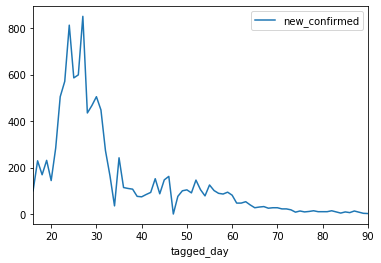

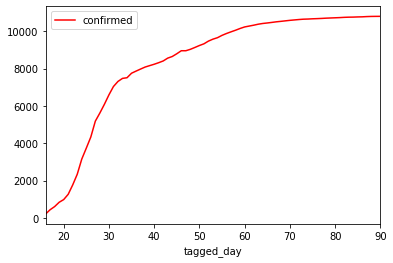

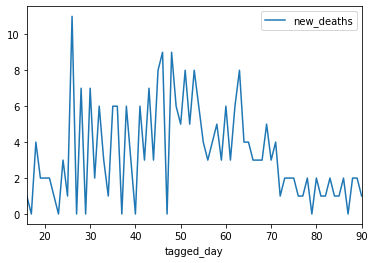

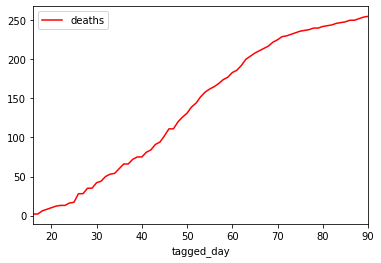

In [49]:
dfkor.plot(x='tagged_day', y='new_confirmed')
dfkor.plot(x='tagged_day', y='confirmed', color = 'red')
dfkor.plot(x='tagged_day', y='new_deaths')
dfkor.plot(x='tagged_day', y='deaths', color = 'red')

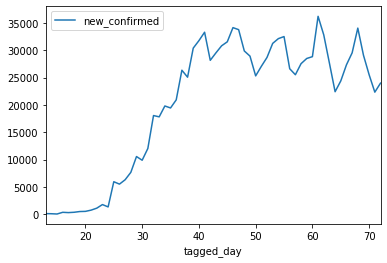

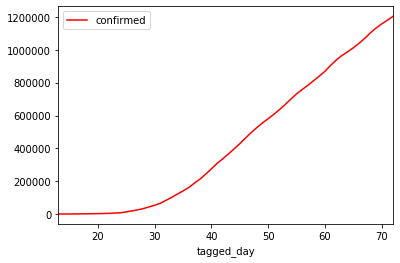

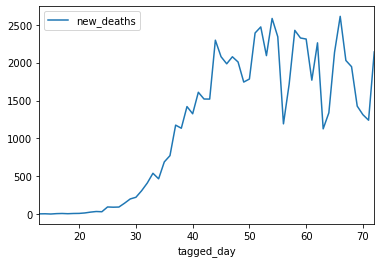

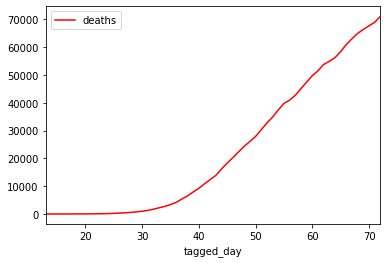

In [50]:
dfusa.plot(x='tagged_day', y='new_confirmed')
dfusa.plot(x='tagged_day', y='confirmed', color = 'red')
dfusa.plot(x='tagged_day', y='new_deaths')
dfusa.plot(x='tagged_day', y='deaths', color = 'red')

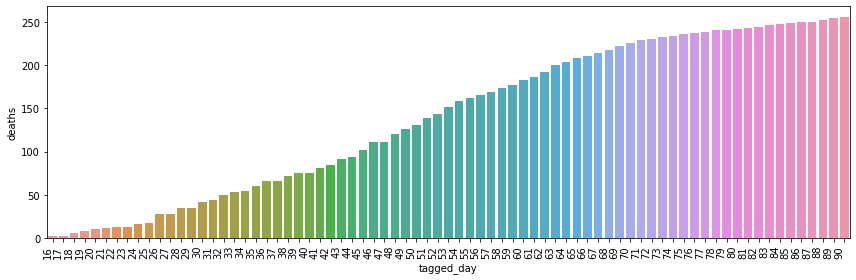

In [51]:
plt.figure(figsize=(12,4))
ax1 = sns.barplot(x="tagged_day", y="deaths", data=dfkor)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

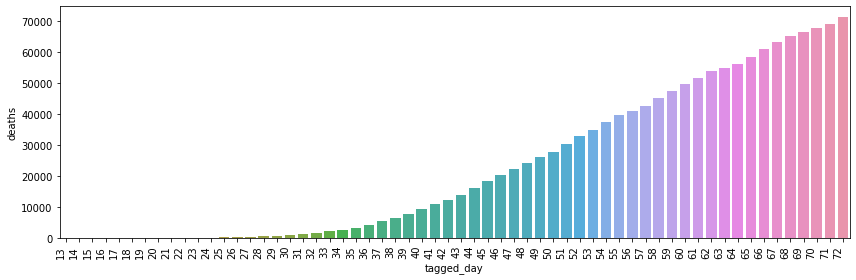

In [52]:
plt.figure(figsize=(12,4))
ax2 = sns.barplot(x="tagged_day", y="deaths", data=dfusa)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

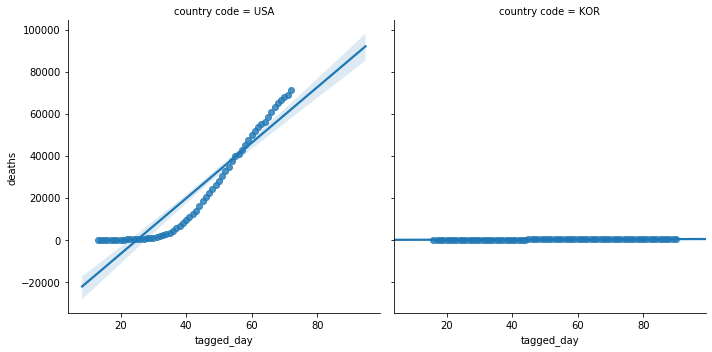

In [53]:
sns.lmplot(x="tagged_day", y="deaths", data = df4, col="country code")

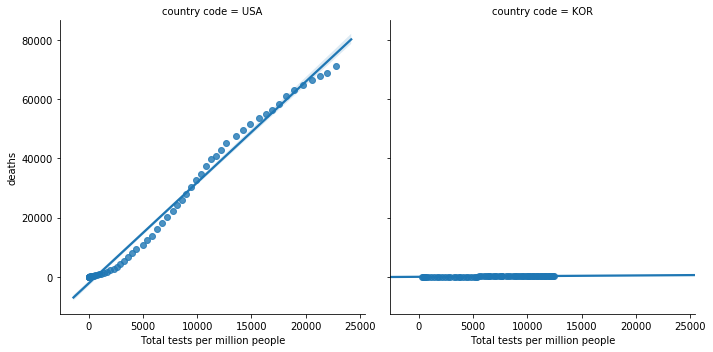

In [54]:
sns.lmplot(x="Total tests per million people", y="deaths", data = df4, col="country code")

In [55]:
display(dfkor.corr())
display(dfusa.corr())

,confirmed,deaths,new_confirmed,new_deaths,tagged_day,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
confirmed,1.000000,0.872653,-0.659339,0.089082,0.865574,0.917139,0.874732
deaths,0.872653,1.000000,-0.706401,-0.133891,0.988818,0.991503,0.999844
new_confirmed,-0.659339,-0.706401,1.000000,0.059376,-0.686335,-0.715482,-0.708651
new_deaths,0.089082,-0.133891,0.059376,1.000000,-0.176974,-0.110500,-0.137733
tagged_day,0.865574,0.988818,-0.686335,-0.176974,1.000000,0.991055,0.988400
Total tests per million people,0.917139,0.991503,-0.715482,-0.110500,0.991055,1.000000,0.991888
Total confirmed deaths due to COVID-19 per million people (deaths per million),0.874732,0.999844,-0.708651,-0.137733,0.988400,0.991888,1.000000


,confirmed,deaths,new_confirmed,new_deaths,tagged_day,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
confirmed,1.000000,0.993977,0.719097,0.786015,0.974158,0.995014,0.983470
deaths,0.993977,1.000000,0.645063,0.730178,0.950225,0.994722,0.996920
new_confirmed,0.719097,0.645063,1.000000,0.899948,0.821915,0.680707,0.596553
new_deaths,0.786015,0.730178,0.899948,1.000000,0.835285,0.740809,0.680252
tagged_day,0.974158,0.950225,0.821915,0.835285,1.000000,0.964661,0.931267
Total tests per million people,0.995014,0.994722,0.680707,0.740809,0.964661,1.000000,0.988997
Total confirmed deaths due to COVID-19 per million people (deaths per million),0.983470,0.996920,0.596553,0.680252,0.931267,0.988997,1.000000


In [103]:
# Split sequentially into train and test
X_train_kor = dfkor['tagged_day'].iloc[0:50]
y_train_kor = dfkor['deaths'].iloc[0:50]
X_test_kor = dfkor['tagged_day'].iloc[51:]
y_test_kor = dfkor['deaths'].iloc[51:]

In [105]:
print( len(X_train_kor), len(y_train_kor) )
print( len(X_test_kor), len(y_test_kor) )

50 50
24 24


# Logistic model: regression

In [106]:
def logistic_model(x, a, b, c):
    """"Uses Logistic Model (https://en.wikipedia.org/wiki/Logistic_regression) to fit the curve of infected
        individuals to a Logistic Curve f(x, a, b, c) = c / (1 + exp(-(x-b)/a))
        Parameters:
        - x : (float) Time to evaluate the infected curve
        - a, b, c : (float) Logistic Curve paramters"""
#    return c / (1 + np.exp(-(x - b) / a))
    return c / (1 + a * np.exp(-b * x))

In [108]:
# initializing parameters
a0 = y_train_kor.min()
b0 = np.random.exponential(size=1)[0]
c0 = 51.64e6 #population of SOuth Korea in 2018(https://www.worldometers.info/world-population/south-korea-population/)
p0 = np.array([a0,b0,c0])
p0

array([2.00000000e+00, 1.25162166e-01, 5.16400000e+07])

In [109]:
(a,b,c),cov = optim.curve_fit(logistic_model, X_train_kor, y_train_kor, p0=p0)

In [110]:
a,b,c

(101.32143998820588, 0.09612512177121958, 243.41184508622354)

Text(0, 0.5, 'Deaths')

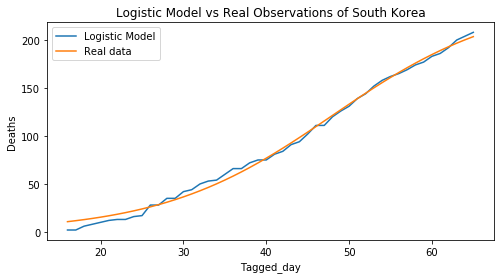

In [124]:
# model predictions on trainig dataset
y_train_kor_pred = logistic_model( X_train_kor, a, b, c)
plt.figure(figsize=(8,4))
plt.plot(X_train_kor, y_train_kor)
plt.plot(X_train_kor, y_train_kor_pred)
plt.title('Logistic Model vs Real Observations of South Korea')
plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Tagged_day')
plt.ylabel('Deaths')

In [115]:
# model predictions on testing dataset
y_test_kor_pred = round( logistic_model(X_test_kor, a, b, c) ).astype('int')
y_test_kor_pred

138    210
139    212
140    215
141    217
142    219
143    221
144    223
145    225
146    226
147    228
148    229
149    230
150    232
151    233
152    234
153    234
154    235
155    236
156    237
157    237
158    238
159    238
160    239
161    239
Name: tagged_day, dtype: int64


Text(0, 0.5, 'Deaths')

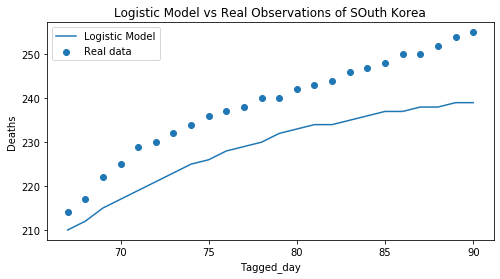

In [119]:
# model predictions on testing dataset
plt.figure(figsize=(8,4))
plt.scatter(X_test_kor, y_test_kor)
plt.plot(X_test_kor, y_pred )
plt.title('Logistic Model vs Real Observations of SOuth Korea')
plt.legend([ 'Logistic Model', 'Real data'])
plt.xlabel('Tagged_day')
plt.ylabel('Deaths')